In [1]:
from __future__ import print_function # so print doesn't show brackets
import numpy as np
import itertools as itr
import csv

import os as os
import sys as sys 
import pandas as pd
import warnings
import time as time
import random
import pickle
pickle.HIGHEST_PROTOCOL = 2
sys.path.append(os.path.join("..", "Libraries","QML_lib"))
from RedisSettings import *
import Evo as evo
import DataBase 
from QMD import QMD #  class moved to QMD in Library
import QML
import DataBase as DB
import ModelGeneration 
import BayesF
import matplotlib.pyplot as plt
import PlotQMD as ptq
#from pympler import asizeof
import matplotlib.pyplot as plt
paulis = ['x', 'y', 'z'] # will be chosen at random. or uncomment below and comment within loop to hard-set

import viz_library as v
import time as time 
import argparse

parser = argparse.ArgumentParser(description='Pass variables for (I)QLE.')

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

import pandas
import matplotlib.cbook as cb
cb.iterable(np.array(0))

False

In [2]:
qmd=pickle.load(open(os.path.normpath(os.getcwd()+'/Results/multtestdir/qmd_class_001.p'), "rb"))

In [3]:
def get_bayes_latex_dict(qmd):
    latex_dict = {}
    for i in list(qmd.AllBayesFactors.keys()):
        mod_a = DataBase.latex_name_ising(qmd.ModelNameIDs[i])
        latex_dict[mod_a] = {}
        for j in list(qmd.AllBayesFactors[i].keys()):
            mod_b = DataBase.latex_name_ising(qmd.ModelNameIDs[j])
            latex_dict[mod_a][mod_b]= qmd.AllBayesFactors[i][j][-1]
    return latex_dict


def updateAllBayesCSV(qmd, all_bayes_csv):
    data = get_bayes_latex_dict(qmd)
    names = list(data.keys())
    fields = ['ModelName']
    fields += names
    all_models= ['ModelName']
    all_models += ising_terms_full_list()
    
    if os.path.isfile(all_bayes_csv) is False:
        with open(all_bayes_csv, 'a') as bayes_csv:
            writer = csv.DictWriter(bayes_csv, fieldnames=all_models)
            writer.writeheader()
    
    with open(all_bayes_csv, 'a') as bayes_csv:
        writer = csv.DictWriter(bayes_csv, fieldnames=all_models)

        for f in names:
            single_model_dict = data[f]
            single_model_dict['ModelName']=f
            writer.writerow(single_model_dict)
    
        
def ising_terms_full_list():
    pauli_terms = ['x','y','z']

    rotation_terms = []
    transverse_terms = []
    hartree_terms = []

    for t in pauli_terms:
        rotation_terms.append(t+'Ti')
        transverse_terms.append(t+'T'+t)
        for k in pauli_terms:
            if k>t:
                hartree_terms.append(t+'T'+k)

    ising_terms = []            
    add = 'PP'

    for r in rotation_terms:
        ising_terms.append(r)

    for r in rotation_terms:
        new_terms=[]
        for i in rotation_terms:
            if r<i:
                new_terms.append(r+add+i)
        ising_terms.extend(new_terms)

    full_rotation = add.join(rotation_terms)
    ising_terms.append(full_rotation)

    for t in transverse_terms:
        new_term = full_rotation+add+t
        ising_terms.append(new_term)

    for t in transverse_terms:
        for k in transverse_terms:
            if t<k:
                dual_transverse_term= full_rotation+add+t+add+k
                ising_terms.append(dual_transverse_term)

    for t in transverse_terms:
        for l in transverse_terms:
            for k in transverse_terms:
                if t<k<l:
                    triple_transverse = full_rotation + add + t + add + k + add + l
                    ising_terms.append(triple_transverse)



    for t in hartree_terms:
        hartree_term= triple_transverse+add+t
        ising_terms.append(hartree_term)


    for t in hartree_terms:
        for k in hartree_terms:
            if t<k:
                dual_hartree_term= triple_transverse+add+t+add+k
                ising_terms.append(dual_hartree_term)

    for t in hartree_terms:
        for l in hartree_terms:
            for k in hartree_terms:
                if t<k<l:
                    triple_hartree_term= triple_transverse+add+t+add+k+add+l
                    ising_terms.append(triple_hartree_term)
    
    latex_terms = [DataBase.latex_name_ising(i) for i in ising_terms]
    
    return latex_terms

In [4]:
def multiQMDBayes(all_bayes_csv):
    import pandas
    cumulative_bayes = pandas.DataFrame.from_csv(all_bayes_csv)
    names=list(cumulative_bayes.keys())

    count_bayes={}
    mod_names= ising_terms_full_list()

    for mod in mod_names:
        count_bayes[mod] = {}
        model_results=cumulative_bayes[mod]
        for comp_mod in mod_names:
            try:
                num_bayes=model_results[comp_mod].count()
            except:
                num_bayes=0
            count_bayes[mod][comp_mod] = num_bayes



    piv = pandas.pivot_table(cumulative_bayes, index='ModelName', values=names, aggfunc=[np.mean, np.median])
    means=piv['mean']
    medians=piv['median']

    b=means.apply(lambda x: x.dropna().to_dict(), axis=1) #to remove NaNs from pivot table before turning to dict.
    means_dict = b.to_dict()

    c=medians.apply(lambda x: x.dropna().to_dict(), axis=1)
    medians_dict = c.to_dict()        
    
    return means_dict, medians_dict, count_bayes

def global_adjacent_branch_test(a,b, term_branches):
    branch_a = term_branches[a]
    branch_b = term_branches[b]
    
    if (branch_a==branch_b) or (branch_a==branch_b+1) or (branch_a==branch_b-1):
        return True
    else:
        return False


In [5]:
import networkx as nx
# parameters of eventual function
bcsv='/home/bf16951/Dropbox/QML_share_stateofart/QMD/ExperimentalSimulations/Results/multtestdir/cumulative.csv'
directed=True
only_adjacent_branches=False


#function

In [6]:
res_csv="/home/bf16951/Dropbox/QML_share_stateofart/QMD/ExperimentalSimulations/Results/multtestdir/param_sweep.csv"
qmd_res = pandas.DataFrame.from_csv(res_csv, index_col='LatexName')
mods = list(qmd_res.index)
winning_count = {}
for mod in mods:
    winning_count[mod]=mods.count(mod)


In [7]:

from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches



def plotTreeDiagram(G, n_cmap, e_cmap, 
                    e_alphas = [], nonadj_alpha=0.1, 
                    label_padding = 0.4, 
                    arrow_size = 0.02, widthscale=1.0,
                    pathstyle = "straight", id_labels = False,
                    save_to_file=None):
    plt.clf()
    plt.figure(figsize=(6,11))   
    
    directed  = nx.is_directed(G)

    if int(nx.__version__[0])>=2: 
        list_of_edges = list(G.edges(data=True))
    
    
    edge_tuples = tuple( G.edges() )
    
    positions = dict( zip( G.nodes(), tuple(  [prop['pos'] for (n,prop) in G.nodes(data=True)]  ) ))
    n_colours = tuple( [ n_cmap(prop['status']) for (n,prop) in G.nodes(data=True)]   )
    
    label_positions = []   
    if id_labels is True:
        labels = dict( zip( G.nodes(), tuple(  [n for (n,prop) in G.nodes(data=True)]  ) ))
        for key in positions.keys():
            label_positions.append( tuple( np.array(positions[key])- np.array([0., 0.]) ) )
    else:
        labels = dict( zip( G.nodes(), tuple(  [prop['label'] for (n,prop) in G.nodes(data=True)]  ) ))  
        for key in positions.keys():
            label_positions.append( tuple( np.array(positions[key])- np.array([0., label_padding]) ) )
    
    label_positions = dict(zip( positions.keys(), tuple(label_positions) ))
     
    
    if len(e_alphas) == 0: 
        for idx in range(len(edge_tuples)):
            e_alphas.append(  0.8 if list_of_edges[idx][2]["adj"] else nonadj_alpha )
    
    weights = tuple( [prop['weight'] for (u,v,prop) in list_of_edges] )

    nx.draw_networkx_nodes(
        G, with_labels = False, # labels=labels, 
        pos=positions, 
        k=1.5, #node spacing
        width=None, 
        node_size=700, #node_shape='8',
        node_color = n_colours
    )  
    
    edges_for_cmap = pt.draw_networkx_arrows(G, edgelist=edge_tuples, pos=positions, arrows=True, 
        arrowstyle='->', width = arrow_size, widthscale=widthscale, pathstyle=pathstyle,
        alphas = e_alphas, edge_color= weights, edge_cmap=e_cmap)
    
    nx.draw_networkx_labels(G, label_positions, labels)
    plt.tight_layout()
    
    plt.gca().invert_yaxis() # so branch 0 on top
    plt.gca().get_xaxis().set_visible(False)
    plt.ylabel('Branch')
    
    xmin = min( np.array(list(label_positions.values()))[:,0] )
    xmax = max( np.array(list(label_positions.values()))[:,0] )
    plt.xlim(xmin -0.8, xmax +0.8)
    
    plt.colorbar(edges_for_cmap, orientation="horizontal", pad= 0, label=r'$\log_{10}$ Bayes factor') # DONE - negative weights are unaccetpable for directed graphs, as they simply mean a flipped edge

    nodes=list(G.nodes)
    distinct_status=[]
    labels=[]
    handles=[]
    for n in nodes:
        stat = G.nodes[n]['status'] # only for status not yet represented in legend
        if stat not in distinct_status:
            distinct_status.append(stat)
            # what does node colour encode? either number wins or branch champion
            info=str(G.nodes[n]['info']) 
            col = tuple( n_cmap(G.nodes[n]['status']) )

            handles.append(mpatches.Patch(color=col))
            labels.append(info)
    labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
    if 'Branch Champion' in labels:
        legend_title='Champion Type'
    else:
        legend_title='# QMD wins'
    plt.legend(handles, labels, title=legend_title)

    #plt.title('Tree Diagram for QMD')
    if save_to_file is not None:
        plt.savefig(save_to_file, bbox_inches='tight')


In [8]:
import PlotQMD as pt

def colour_dicts_from_win_count(winning_count, min_colour_value=0.0):
    max_wins=max(list(winning_count.values()))
    min_wins=min(list(winning_count.values()))
    min_col = min_colour_value
    max_col = 0.9

    win_count_vals = list(winning_count.values())
    win_count_vals.append(0)
    distinct_win_vals=sorted(list(set(win_count_vals)))
    num_colours = len(distinct_win_vals)
    col_space = np.linspace(min_col, max_col, num_colours)
    colour_by_win_count = {}
    colour_by_node_name = {}
    all_models=list(pt.ising_terms_full_list(return_branch_dict='latex_terms').keys())

    for k in range(num_colours):
        colour_by_win_count[k] = col_space[k]


    for k in all_models:
        try:
            num_wins = winning_count[k]
        except:
            num_wins = 0
        idx = distinct_win_vals.index(num_wins)
        colour_by_node_name[k] = colour_by_win_count[idx]
    return colour_by_node_name, colour_by_win_count


def cumulativeQMDTreePlot(cumulative_csv, wins_per_mod, avg='means', 
                          only_adjacent_branches=True, directed=True,
                          save_to_file=None):
    import networkx as nx
    import copy
    means, medians, counts = multiQMDBayes(cumulative_csv)
    if avg=='means':
        bayes_factors = means #medians
    elif avg=='medians':
        bayes_factors = medians

    modlist = pt.ising_terms_full_list()
    term_branches = pt.ising_terms_full_list(return_branch_dict='latex_terms')        

    pair_freqs={}
    for c in list(counts.keys()):
        for k in list(counts[c].keys()):
            this_edge=(c,k)
            pair_freqs[this_edge]=counts[c][k]


    if directed:
        G=nx.DiGraph()
    else:
        G=nx.Graph()

    positions = {}
    branch_x_filled = {}
    branch_mod_count = {}

#    max_branch_id = qmd.HighestBranchID # TODO: get this number without access to QMD class instance
 #   max_mod_id = qmd.HighestModelID
    max_branch_id = 9 # TODO: this is hardcoded - is there an alternative?
    max_mod_id = 17
    
    

    for i in range(max_branch_id+1):
        branch_x_filled[i] = 0
        branch_mod_count[i] =  0 

    colour_by_node_name, colour_by_count = colour_dicts_from_win_count(wins_per_mod, 0.4)
    min_colour = min(list(colour_by_node_name.values()))
    
    for m in modlist:
        branch = term_branches[m]
        branch_mod_count[branch]+=1
        G.add_node(m)
        G.nodes[m]['label']=str(m)
        try:
            G.nodes[m]['status']=colour_by_node_name[m]
            G.nodes[m]['wins']=wins_per_mod[m]
            G.nodes[m]['info']=wins_per_mod[m]
            
            
        except:
            G.nodes[m]['status']=min_colour
            G.nodes[m]['info']=0
            
            
    max_num_mods_any_branch=max(list(branch_mod_count.values()))
    for m in modlist:
        branch = term_branches[m]
        num_mods_this_branch = branch_mod_count[branch]
        pos_list = pt.available_position_list(num_mods_this_branch, max_num_mods_any_branch)
        branch_filled_so_far = branch_x_filled[branch]
        branch_x_filled[branch]+=1

        x_pos = pos_list[branch_filled_so_far]
        y_pos = branch
        positions[i] = (x_pos, y_pos)
        G.node[m]['pos'] = (x_pos, y_pos)

    edges = []
    edge_frequencies=[]
    max_frequency = max(list(pair_freqs.values()))
    for a in modlist:
        remaining_modlist = modlist[modlist.index(a)+1:]
        for b in remaining_modlist:
            is_adj = global_adjacent_branch_test(a, b, term_branches)
            if is_adj or not only_adjacent_branches:
                if a!=b:
                    pairing = (a,b)
                    frequency = pair_freqs[pairing]/max_frequency #TODO build frequency into edges
                    edges.append(pairing)
                    edge_frequencies.append(frequency)
                    vs = [a,b]

                    try:
                        thisweight = np.log10(bayes_factors[a][b])
                    except:
                        thisweight=0 #TODO is this right?

                    if thisweight < 0:
                        thisweight = - thisweight # flip negative valued edges and move them to positive
                        flipped = True
                        G.add_edge(b, a, weight=thisweight, flipped = flipped, adj = is_adj, freq = frequency)
                    else:
                        flipped = False
                        G.add_edge(a, b, weight=thisweight, flipped = flipped, adj = is_adj, freq = frequency)

                        
    max_freq = max(edge_frequencies)
    
    freq_scale = 10/max_freq
    edge_f = [i*freq_scale for i in edge_frequencies]
    
    plotTreeDiagram(G,n_cmap = plt.cm.pink_r, e_cmap = plt.cm.Blues, #TODO should be pt.plot when finished dev
                       nonadj_alpha = 0.1, e_alphas = [] , widthscale=10.5, 
                       label_padding = 0.4, pathstyle="curve", arrow_size=None) #  

    if save_to_file is not None:
        plt.savefig(save_to_file, bbox_inches='tight')
    return G, edges, edge_f

<Figure size 432x288 with 0 Axes>

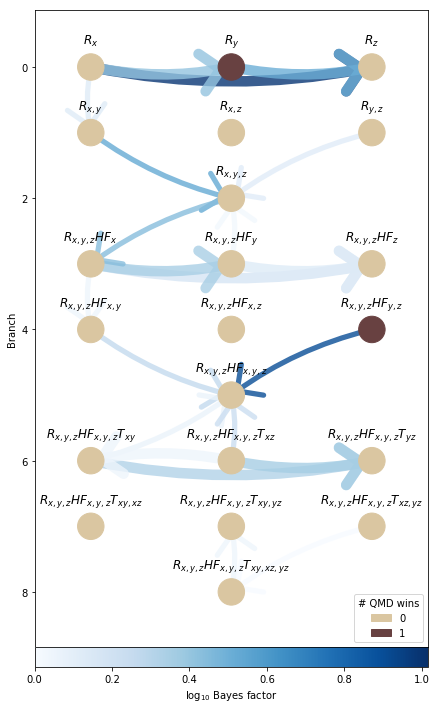

In [9]:
# something based on: https://stackoverflow.com/questions/44595288/matplotlib-adding-legend-based-on-existing-color-series

#with set_clim turned off
G, edges, edge_f=cumulativeQMDTreePlot(cumulative_csv=bcsv, wins_per_mod = winning_count, only_adjacent_branches=True, avg='medians', save_to_file='example_cumulative_bayes_medians.png')        

In [10]:
G.edges[('$R_{z}$', '$R_{y}$')]

KeyError: '$R_{y}$'

In [12]:
G.edges[('$R_{y,z}$', '$R_{x,y,z}$')]

{'adj': True, 'flipped': False, 'freq': 0.5, 'weight': 0.11470730815553096}

In [14]:
G.edges[('$R_{z}$', '$R_{y,z}$')]

{'adj': True, 'flipped': False, 'freq': 0.0, 'weight': 0}